# Modelo de espacio latente en $\mathbb{S}^1$ para la red de las familias florentinas

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import expit
import pandas as pd
from tqdm import tqdm
np.random.seed(42)

In [45]:
def log_likelihood(A, thetas, alpha, beta):
    n = A.shape[0]
    thetas = np.mod(thetas, 2*np.pi)
    ll = 0.0
    for i in range(n):
        for j in range(i + 1, n):
            distance = np.min([
                np.abs(thetas[i] - thetas[j]),
                2*np.pi - np.abs(thetas[i] - thetas[j])
            ])
            eta = alpha + beta * np.cos(distance)
            ll += eta * A[i,j] - np.log(1 + np.exp(eta))
    return ll

def log_prior(thetas, alpha, beta):
    
    sigma_theta=10.0
    sigma_alpha=1.0 
    sigma_beta=1.0

    lp = -0.5 * np.sum((thetas/ sigma_theta)**2)
    lp += -0.5 * ((alpha + 1)/ sigma_alpha)**2
    lp += -0.5 * ((beta - 1) / sigma_beta)**2
    return lp

def estimate_mle(A, init_thetas=None, init_alpha=-1.0, init_beta=3.0):
    from scipy.optimize import minimize
    def negative_log_likelihood(params, A):
        n = A.shape[0]
        thetas = params[:n]
        alpha = params[n]
        beta = params[n + 1]
        return -log_likelihood(A, thetas, alpha, beta)
    n = A.shape[0]
    
    if init_thetas is None:
        init_thetas = np.random.uniform(0, 2 * np.pi, size=n)
    
    x0 = np.concatenate([init_thetas, [init_alpha, init_beta]])

    result = minimize(negative_log_likelihood, x0, args=(A,), method='L-BFGS-B')

    if result.success:
        mle_thetas = np.mod(result.x[:n], 2 * np.pi)
        mle_alpha = result.x[n]
        mle_beta = result.x[n + 1]
        return mle_thetas, mle_alpha, mle_beta, result
    else:
        raise RuntimeError("MLE optimization failed: " + result.message)

def compute_starS1(ang_old, ang_ref):
    addition = np.mean(ang_ref-ang_old)
    ang_new = ang_old + addition
    return ang_new

def mh(
    A, n_samples=50000, step_theta=0.01, step_alpha=0.5, step_beta=0.5,
    burn_in=2500, thinning=5
):
    print("Initialization of Metropolis Hastings")
    print("Number of samples: ",n_samples)
    print("Number of burn-in: ", burn_in)
    print("Thinning: ",thinning)
    print("Initial step theta: ",step_theta)
    print("Initial step alpha: ",step_alpha)
    print("Initial step beta: ",step_beta)

    n = A.shape[0]
    samples_theta = np.zeros((n_samples+ burn_in, n))
    samples_alpha = np.zeros(n_samples+ burn_in)
    samples_beta = np.zeros(n_samples+ burn_in)
    log_likelihoods = np.zeros(n_samples+ burn_in)
    log_priors = np.zeros(n_samples+ burn_in)
    log_posteriors = np.zeros(n_samples+ burn_in)
    accept_history = np.zeros(n_samples+ burn_in)

    accept_count = 0

    thetas_ml, alpha_ml, beta_ml, _ = estimate_mle(Y)

    print("Log posterior of ML: ", log_likelihood(A, thetas_ml, alpha_ml, beta_ml) + log_prior(thetas_ml, alpha_ml, beta_ml))

    thetas = 2*np.pi*np.random.rand(n)
    alpha = np.random.randn()
    beta = np.random.randn()

    current_ll = log_likelihood(A, thetas, alpha, beta)
    current_lp = log_prior(thetas, alpha, beta)
    current_log_post = current_ll + current_lp

    for i in tqdm(range(n_samples + burn_in)):

        thetas_prop = thetas + np.random.normal(0, step_theta, n)
        alpha_prop = alpha + np.random.normal(0, step_alpha)
        beta_prop = beta + np.random.normal(0, step_beta)

        ll_prop = log_likelihood(A, thetas_prop, alpha_prop, beta_prop)
        lp_prop = log_prior(thetas_prop, alpha_prop, beta_prop)
        log_post_prop = ll_prop + lp_prop

        log_accept_ratio = log_post_prop - current_log_post
        if np.log(np.random.rand()) < log_accept_ratio:
            thetas, alpha, beta = thetas_prop, alpha_prop, beta_prop
            current_ll, current_lp, current_log_post = ll_prop, lp_prop, log_post_prop
            accept_count += 1

        if i<=burn_in:
            samples_theta[i, :] = np.mod(thetas, 2 * np.pi)
        else:
            samples_theta[i, :] = np.mod(compute_starS1(np.mod(thetas, 2 * np.pi), samples_theta[burn_in, :]), 2 * np.pi)


        samples_alpha[i] = alpha
        samples_beta[i] = beta
        log_likelihoods[i] = current_ll
        log_priors[i] = current_lp
        log_posteriors[i] = current_log_post
        accept_history[i] = accept_count / (i + 1)

        # Ajuste de hiperparámetros
        if (i % 10 == 0) and (0 < i <= burn_in):
            if accept_history[i] > 0.8:
                step_theta *= 1.01
                #step_alpha *= 1.01
                #step_beta *= 1.01
            elif accept_history[i] < 0.6:
                step_theta *= 0.99
                #step_alpha *= 0.99
                #step_beta *= 0.99
        if i == burn_in:
            print(f"Finished burn-in")
            print("Final step theta: ",step_theta)
            print("Final step alpha: ",step_alpha)
            print("Final step beta: ",step_beta)

    # Estimadores MAP
    idx_map = np.argmax(log_posteriors[burn_in:])
    theta_map = samples_theta[idx_map]
    alpha_map = samples_alpha[idx_map]
    beta_map = samples_beta[idx_map]

    # Estimadores CM (media posterior)
    theta_cm = np.mean(samples_theta[burn_in:], axis=0)
    alpha_cm = np.mean(samples_alpha[burn_in:])
    beta_cm = np.mean(samples_beta[burn_in:])



    print("Log posterior of MAP: ", log_likelihood(A, theta_map, alpha_map, beta_map) + log_prior(theta_map, alpha_map, beta_map))
    print("Log posterior of CM: ", log_likelihood(A, theta_cm, alpha_cm, beta_cm) + log_prior(theta_cm, alpha_cm, beta_cm))

    return {
        "samples": {
            "theta": samples_theta,
            "alpha": samples_alpha,
            "beta": samples_beta
        },
        "log_likelihood": log_likelihoods[burn_in::thinning],
        "log_prior": log_priors[burn_in::thinning],
        "log_posterior": log_posteriors[burn_in::thinning],
        "acceptance_history": accept_history[burn_in::thinning],
        "ML": {
            "theta": thetas_ml,
            "alpha": alpha_map,
            "beta": beta_map
        },
        "MAP": {
            "theta": theta_map,
            "alpha": alpha_map,
            "beta": beta_map
        },
        "CM": {
            "theta": theta_cm,
            "alpha": alpha_cm,
            "beta": beta_cm
        },
        "thinned_samples": {
            "theta": samples_theta[burn_in::thinning],
            "alpha": samples_alpha[burn_in::thinning],
            "beta": samples_beta[burn_in::thinning]
        }
    }

# plot
def plot_diagnostics(x1,x2,x3,x4):
    iterations2 = np.arange(1, len(x2) + 1)
    data2 = pd.DataFrame({'Iteration': iterations2, 'Values': x2})
    mean2 = np.mean(x2)
    quantiles2 = np.quantile(x2, [0.025, 0.975])

    iterations3 = np.arange(1, len(x3) + 1)
    data3 = pd.DataFrame({'Iteration': iterations3, 'Values': x3})
    mean3 = np.mean(x3)
    quantiles3 = np.quantile(x3, [0.025, 0.975])

    iterations4 = np.arange(1, len(x4) + 1)
    data4 = pd.DataFrame({'Iteration': iterations4, 'Values': x4})
    mean4 = np.mean(x4)
    quantiles4 = np.quantile(x4, [0.025, 0.975])

    fig, axs = plt.subplots(1, 4, figsize=(18, 4)) 

    # Subplot 1: Acceptance rate
    axs[0].plot(x1, color='black', alpha=0.9, linewidth=2)
    axs[0].axhline(0.80, color='red', linestyle=':', linewidth=2)
    axs[0].axhline(0.60, color='red', linestyle=':', linewidth=2)
    axs[0].set_xlabel("Iteration")
    axs[0].set_ylabel("Acceptance rate")
    axs[0].set_title("Acceptance rate over iterations")
    axs[0].set_ylim(-0.05, 1.05)
    axs[0].grid(True)

    # Subplot 2
    sns.scatterplot(ax=axs[1], x='Iteration', y='Values', data=data2, color='black', alpha=0.3, s=10)
    axs[1].axhline(mean2, color='blue', linestyle='--', linewidth=1, label='Mean')
    axs[1].axhline(quantiles2[0], color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
    axs[1].axhline(quantiles2[1], color='red', linestyle=':', linewidth=1)
    axs[1].set_xlabel("Iteration")
    axs[1].set_ylabel("LogLikelihood")
    axs[1].legend()

    # Subplot 3
    sns.scatterplot(ax=axs[2], x='Iteration', y='Values', data=data3, color='black', alpha=0.3, s=10)
    axs[2].axhline(mean3, color='blue', linestyle='--', linewidth=1, label='Mean')
    axs[2].axhline(quantiles3[0], color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
    axs[2].axhline(quantiles3[1], color='red', linestyle=':', linewidth=1)
    axs[2].set_xlabel("Iteration")
    axs[2].set_ylabel("LogPriori")
    axs[2].legend()

    # Subplot 4
    sns.scatterplot(ax=axs[3], x='Iteration', y='Values', data=data4, color='black', alpha=0.3, s=10)
    axs[3].axhline(mean4, color='blue', linestyle='--', linewidth=1, label='Mean')
    axs[3].axhline(quantiles4[0], color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
    axs[3].axhline(quantiles4[1], color='red', linestyle=':', linewidth=1)
    axs[3].set_xlabel("Iteration")
    axs[3].set_ylabel("LogPosterior")
    axs[3].legend()

    sns.despine()
    plt.tight_layout()
    plt.show()




import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

def plot_alpha_beta(a,b):
    iterations = np.arange(1, len(a) + 1)

    mean_a = np.mean(a)
    quantiles_a = np.quantile(a, [0.025, 0.975])

    mean_b = np.mean(b)
    quantiles_b = np.quantile(b, [0.025, 0.975])


    fig, axes = plt.subplots(2, 2, figsize=(14, 8), constrained_layout=True)

    sns.scatterplot(x=iterations, y=a, color='black', alpha=0.3, s=10, ax=axes[0,0])
    axes[0,0].axhline(mean_a, color='blue', linestyle='--', linewidth=1, label='Mean')
    axes[0,0].axhline(quantiles_a[0], color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
    axes[0,0].axhline(quantiles_a[1], color='red', linestyle=':', linewidth=1)
    axes[0,0].set_xlabel("Iteration")
    axes[0,0].set_ylabel(r"$\alpha$")
    axes[0,0].set_title("Markov Chain")
    axes[0,0].legend()
    sns.despine(ax=axes[0,0])

    sns.histplot(a, bins=50, kde=False, stat='density', color='gray', edgecolor='white', ax=axes[0,1])
    axes[0,1].axvline(mean_a, color='blue', linestyle='--', linewidth=1, label='Mean')
    axes[0,1].axvline(quantiles_a[0], color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
    axes[0,1].axvline(quantiles_a[1], color='red', linestyle=':', linewidth=1)
    axes[0,1].set_xlabel(r"$\alpha$")
    axes[0,1].set_ylabel("Density")
    axes[0,1].set_title("Marginal distribution")
    axes[0,1].legend()
    sns.despine(ax=axes[0,1])

    sns.scatterplot(x=iterations, y=b, color='black', alpha=0.3, s=10, ax=axes[1,0])
    axes[1,0].axhline(mean_b, color='blue', linestyle='--', linewidth=1, label='Mean')
    axes[1,0].axhline(quantiles_b[0], color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
    axes[1,0].axhline(quantiles_b[1], color='red', linestyle=':', linewidth=1)
    axes[1,0].set_xlabel("Iteration")
    axes[1,0].set_ylabel(r"$\beta$")
    axes[1,0].set_title("Markov Chain")
    axes[1,0].legend()
    sns.despine(ax=axes[1,0])

    sns.histplot(b, bins=50, kde=False, stat='density', color='gray', edgecolor='white', ax=axes[1,1])
    axes[1,1].axvline(mean_b, color='blue', linestyle='--', linewidth=1, label='Mean')
    axes[1,1].axvline(quantiles_b[0], color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
    axes[1,1].axvline(quantiles_b[1], color='red', linestyle=':', linewidth=1)
    axes[1,1].set_xlabel(r"$\beta$")
    axes[1,1].set_ylabel("Density")
    axes[1,1].set_title("Marginal distribution")
    axes[1,1].legend()
    sns.despine(ax=axes[1,1])

    plt.show()


def plot_all_circular_histograms(samples_theta, theta_map=None, theta_cm=None,
                                  bins=50, inner_padding=0.2):
    """
    Plot circular histograms for each node in polar coordinates.
    
    Parameters:
    -----------
    - samples_theta: array of shape (n_samples, n_nodes) with angular samples in radians
    - theta_map: array of MAP estimates per node (optional)
    - theta_cm: array of posterior means per node (optional)
    - bins: number of histogram bins (angular divisions)
    - inner_padding: fraction of maximum radius used as the base of the bars
    """
    n_nodes = samples_theta.shape[1]
    n_cols = 5
    n_rows = int(np.ceil(n_nodes / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, subplot_kw={'projection': 'polar'}, figsize=(15, 3.2 * n_rows))
    axes = axes.flatten()

    for i in range(n_nodes):
        ax = axes[i]

        thetas = samples_theta[:, i]
        counts, bin_edges = np.histogram(thetas, bins=bins, range=(0, 2*np.pi))
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        max_count = np.max(counts)
        inner_radius = inner_padding * max_count
        radii = inner_radius + 3*counts

        # Histogram bars
        ax.bar(
            bin_centers,
            radii,
            width=2*np.pi/bins,
            bottom=inner_radius,
            color='lightgray',
            edgecolor='lightgray',
            alpha=0.9
        )

        # Add MAP line in red
        if theta_map is not None:
            angle = theta_map[i]
            ax.plot([angle, angle], [0, inner_radius + 3*max_count], color='red', linestyle='--', linewidth=1.3, label="MAP")

        # Add CM line in blue
        if theta_cm is not None:
            angle = theta_cm[i]
            ax.plot([angle, angle], [0, inner_radius + 3*max_count], color='blue', linestyle='--', linewidth=1.3, label="CM")

        ax.set_yticklabels([])
        ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])
        ax.set_xticklabels(["0", "π/2", "π", "3π/2"])
        ax.set_title(f'Node {i}', fontsize=10)
        ax.grid(False)

    # Remove empty subplots
    for j in range(n_nodes, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle('Circular histograms per node', fontsize=16)
    plt.legend(['CM','MAP'], loc='upper right')
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MultipleLocator, FuncFormatter



def plot_theta_chains_and_marginals(theta_samples, pi_tick_denominator=256):
    """
    Plot trace and marginal distribution for each node's theta samples,
    with axis ticks in multiples of π/denominator.

    Parameters:
    -----------
    theta_samples : np.ndarray, shape (n_samples, n_nodes)
        MCMC samples of the parameter θ for each node.
    pi_tick_denominator : int
        The denominator for the tick marks as multiples of π (e.g., 256 for π/256).
    """


    def format_radians_factory(denominator):
        def formatter(x, pos):
            frac = x / np.pi
            numerator = round(frac * denominator)
            if numerator == 0:
                return "0"
            elif numerator == denominator:
                return r"$\pi$"
            elif numerator == 2 * denominator:
                return r"$2\pi$"
            elif numerator == -denominator:
                return r"$-\pi$"
            elif numerator == -2 * denominator:
                return r"$-2\pi$"
            else:
                sign = "-" if numerator < 0 else ""
                numerator = abs(numerator)
                if numerator % denominator == 0:
                    return fr"${sign}{numerator // denominator}\pi$"
                else:
                    return fr"${sign}{numerator}\pi/{denominator}$"
        return formatter

    n_samples, n_nodes = theta_samples.shape
    iterations = np.arange(1, n_samples + 1)

    formatter = FuncFormatter(format_radians_factory(pi_tick_denominator))
    locator = MultipleLocator(base=np.pi / pi_tick_denominator)

    for i in range(n_nodes):
        theta_i = theta_samples[:, i]
        mean_theta = np.mean(theta_i)
        quantiles = np.quantile(theta_i, [0.025, 0.975])

        fig, axes = plt.subplots(1, 2, figsize=(12.5, 2.5), constrained_layout=True)

        # Trace plot
        sns.scatterplot(x=iterations, y=theta_i, color='black', alpha=0.3, s=10, ax=axes[0])
        axes[0].axhline(mean_theta, color='blue', linestyle='--', linewidth=1, label='Mean')
        axes[0].axhline(quantiles[0], color='red', linestyle=':', linewidth=1, label='2.5% and 97.5%')
        axes[0].axhline(quantiles[1], color='red', linestyle=':', linewidth=1)
        axes[0].set_xlabel("Iteration")
        axes[0].set_ylabel(r"$\theta$")
        axes[0].set_title(f"Markov Chain – Node {i}")
        axes[0].yaxis.set_major_locator(locator)
        axes[0].yaxis.set_major_formatter(formatter)
        sns.despine(ax=axes[0])

        # Marginal histogram
        sns.histplot(theta_i, bins=30, kde=False, stat='density',
                     color='lightgray', edgecolor='white', ax=axes[1])
        axes[1].axvline(mean_theta, color='blue', linestyle='--', linewidth=1, label='Mean')
        axes[1].axvline(quantiles[0], color='red', linestyle=':', linewidth=1, label='2.5% and 97.5%')
        axes[1].axvline(quantiles[1], color='red', linestyle=':', linewidth=1)
        axes[1].set_xlabel(r"$\theta$")
        axes[1].set_ylabel("Density")
        axes[1].set_title(f"Marginal Distribution – Node {i}")
        axes[1].xaxis.set_major_locator(locator)
        axes[1].xaxis.set_major_formatter(formatter)
        axes[1].legend(loc="center left", bbox_to_anchor=(1, 0.5))
        sns.despine(ax=axes[1])

        plt.show()



def compute_Y_est(thetas, alpha, beta, n):
    Y_est = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                distance = np.min([
                    np.abs(thetas[i] - thetas[j]),
                    2 * np.pi - np.abs(thetas[i] - thetas[j])
                ])
                Y_est[i, j] = expit(alpha - beta * distance)
    return Y_est

Considere el grafo que representa la red de familias florentinas, como se puede evidenciar este grafo es conexo, tiene un total de 15 nodos

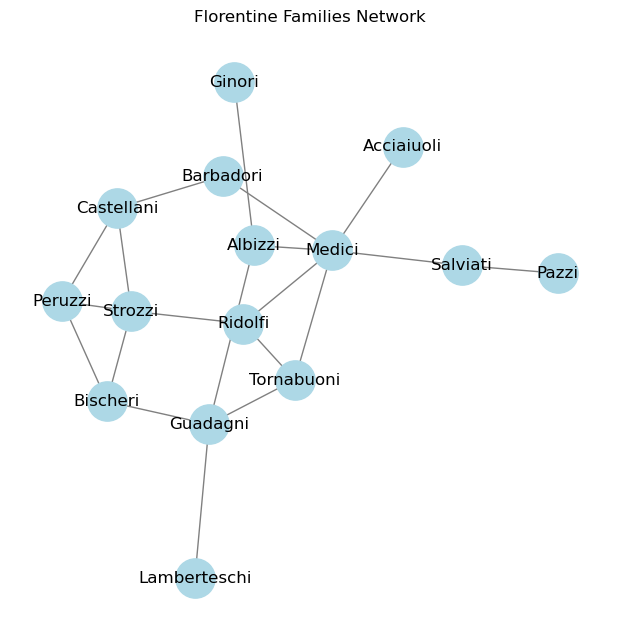

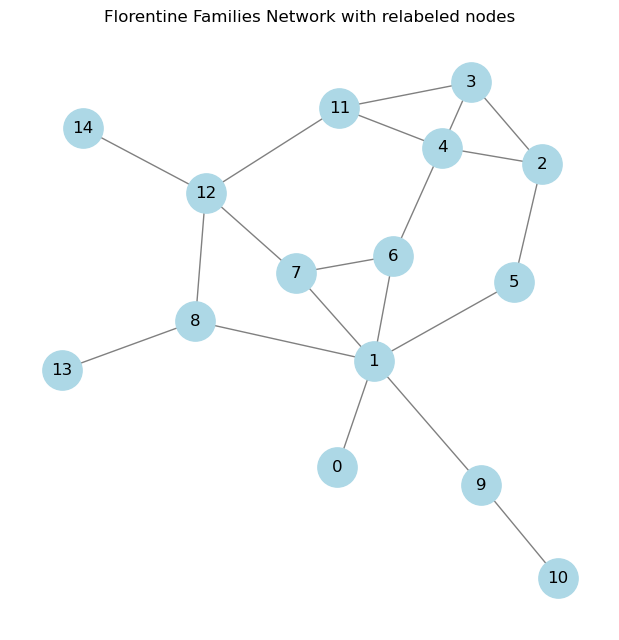

Map from original nodes to new nodes:
{'Acciaiuoli': 0, 'Medici': 1, 'Castellani': 2, 'Peruzzi': 3, 'Strozzi': 4, 'Barbadori': 5, 'Ridolfi': 6, 'Tornabuoni': 7, 'Albizzi': 8, 'Salviati': 9, 'Pazzi': 10, 'Bischeri': 11, 'Guadagni': 12, 'Ginori': 13, 'Lamberteschi': 14}


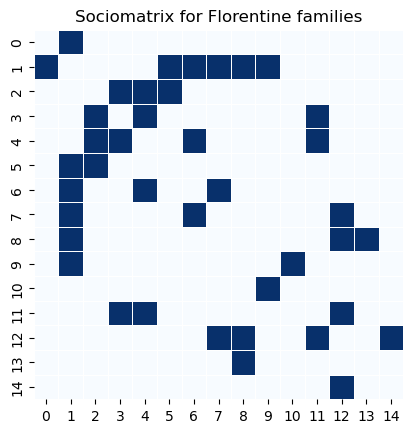

In [12]:
G = nx.florentine_families_graph()

plt.figure(figsize=(6,6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=800)
plt.title("Florentine Families Network")
plt.show()

G = nx.florentine_families_graph()
node_mapping = {node: i for i, node in enumerate(G.nodes())}
G = nx.relabel_nodes(G, node_mapping)
n = len(G.nodes)
plt.figure(figsize=(6,6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=800)
plt.title("Florentine Families Network with relabeled nodes")
plt.show()
print("Map from original nodes to new nodes:")
print(node_mapping)

Y = nx.to_numpy_array(G, dtype=float)

sns.heatmap(Y, annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("Sociomatrix for Florentine families")
plt.show()

In [50]:
mh_results = mh(Y, n_samples=200000, step_theta=0.025, step_alpha=1.0, step_beta=1.0, burn_in=10000, thinning=10)

theta_samples = mh_results["thinned_samples"]["theta"]
alpha_samples = mh_results["thinned_samples"]["alpha"]
beta_samples = mh_results["thinned_samples"]["beta"]
log_lik = mh_results["log_likelihood"]
log_priori = mh_results["log_prior"]
log_post = mh_results["log_posterior"]
accept_history = mh_results["acceptance_history"]

theta_ml = mh_results["ML"]["theta"]
alpha_ml= mh_results["ML"]["alpha"]
beta_ml = mh_results["ML"]["beta"]
theta_map = mh_results["MAP"]["theta"]
alpha_map = mh_results["MAP"]["alpha"]
beta_map = mh_results["MAP"]["beta"]
theta_cm = mh_results["CM"]["theta"]
alpha_cm = mh_results["CM"]["alpha"]
beta_cm = mh_results["CM"]["beta"]


Initialization of Metropolis Hastings
Number of samples:  200000
Number of burn-in:  10000
Thinning:  10
Initial step theta:  0.025
Initial step alpha:  1.0
Initial step beta:  1.0
Log posterior of ML:  -37.982965743675756


  5%|▍         | 10158/210000 [00:18<05:36, 594.02it/s]

Finished burn-in
Final step theta:  1.0792811852664486e-06
Final step alpha:  1.0
Final step beta:  1.0


100%|██████████| 210000/210000 [06:19<00:00, 553.25it/s]

Log posterior of MAP:  -52.76986981454572
Log posterior of CM:  -52.09289550243787


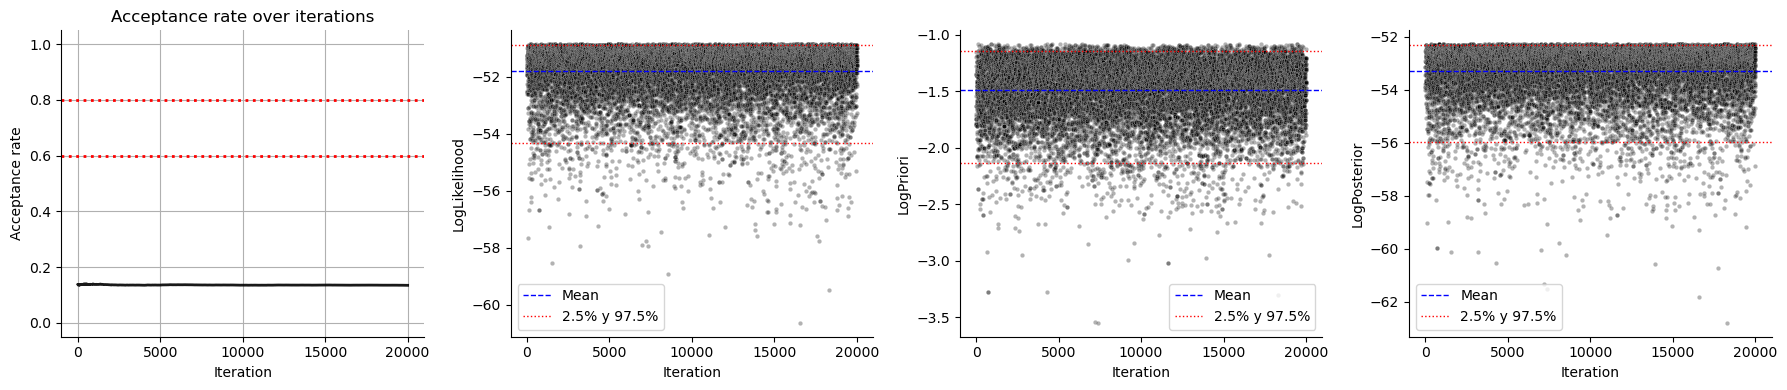

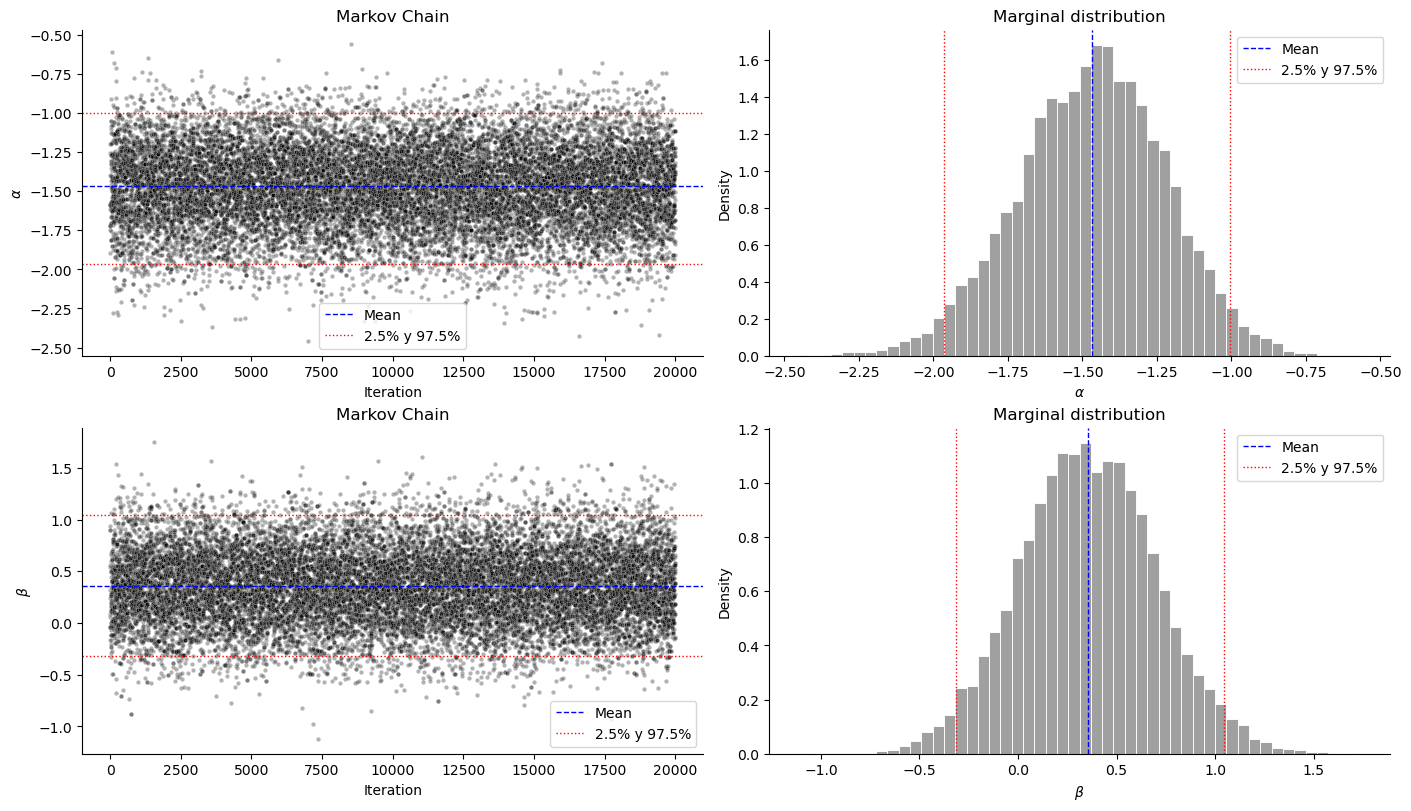

In [51]:
plot_diagnostics(accept_history,log_lik,log_priori,log_post)
plot_alpha_beta(alpha_samples,beta_samples) 

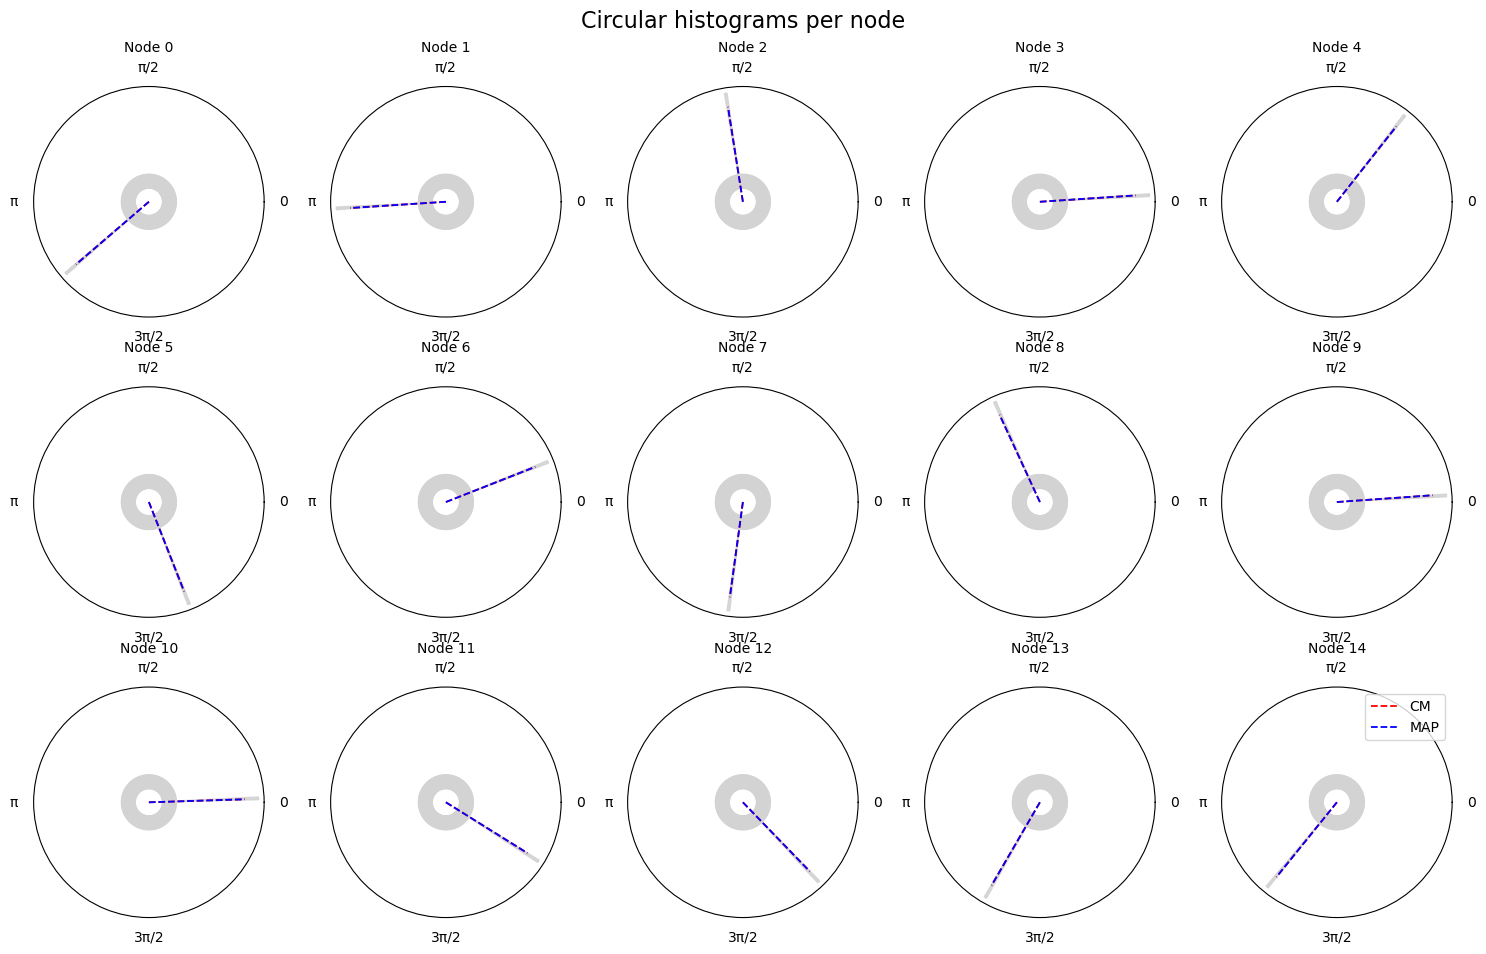

In [56]:
plot_all_circular_histograms(
    samples_theta=theta_samples,
    theta_map=theta_map,
    theta_cm=theta_cm,
    bins=200,
    inner_padding=0.5
)
#plot_theta_chains_and_marginals(theta_samples, 4)

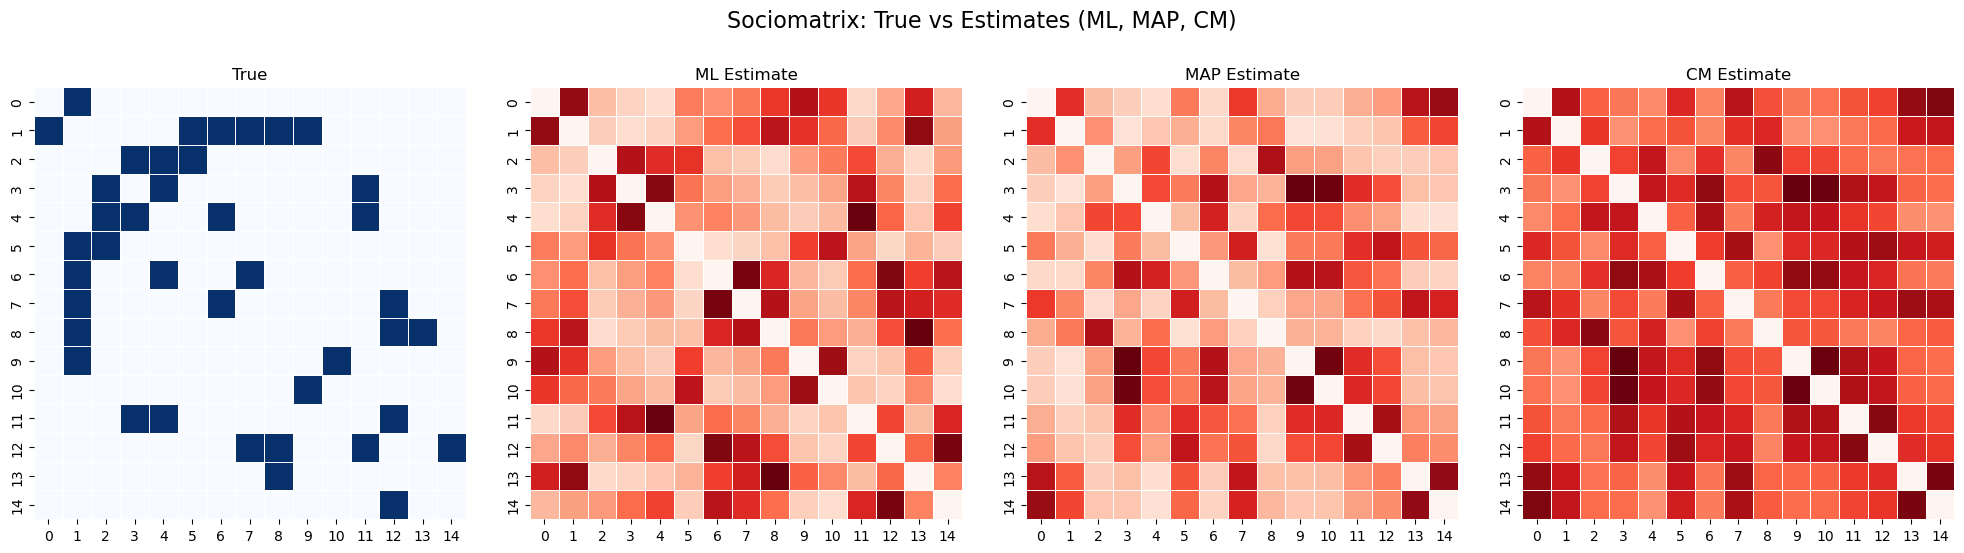

In [53]:


# Estimaciones para ML, MAP y CM
Y_ML = compute_Y_est(theta_ml, alpha_ml, beta_ml, n)
Y_MAP = compute_Y_est(theta_map, alpha_map, beta_map, n)
Y_CM = compute_Y_est(theta_cm, alpha_cm, beta_cm, n)

# Gráficas
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle("Sociomatrix: True vs Estimates (ML, MAP, CM)", fontsize=16, y=1.05)

sns.heatmap(Y, ax=axes[0], cmap="Blues", cbar=False, square=True,
            linewidths=0.5, linecolor='white')
axes[0].set_title("True")

sns.heatmap(Y_ML, ax=axes[1], cmap="Reds", cbar=False, square=True,
            linewidths=0.5, linecolor='white')
axes[1].set_title("ML Estimate")

sns.heatmap(Y_MAP, ax=axes[2], cmap="Reds", cbar=False, square=True,
            linewidths=0.5, linecolor='white')
axes[2].set_title("MAP Estimate")

sns.heatmap(Y_CM, ax=axes[3], cmap="Reds", cbar=False, square=True,
            linewidths=0.5, linecolor='white')
axes[3].set_title("CM Estimate")

plt.tight_layout()
plt.show()